In [1]:
import os
import sys

from collections import defaultdict, Counter
from tqdm.notebook import tqdm_notebook

import numpy as np
import pandas as pd
import scipy.stats as sps
import scipy.sparse as scsp
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import ndcg_score, dcg_score, roc_auc_score, average_precision_score
from sklearn.metrics.pairwise import cosine_similarity

from joblib import Parallel, delayed

import tqdm
import json

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, clear_output

sns.set()

# Датасет

In [2]:
# !wget -O zen_dataset.tar.gz https://www.dropbox.com/s/15mkthbvlturbsz/zen_dataset.tar.gz?dl=0
# !tar -xzvf zen_dataset.tar.gz

In [3]:
item_counts = pd.read_csv('zen_dataset/item_counts.csv', index_col=0)
item_meta = pd.read_csv('zen_dataset/item_meta.gz', compression='gzip', index_col=0)
user_ratings = pd.read_csv('zen_dataset/user_ratings.gz', compression='gzip', index_col=0)

In [4]:
item_counts['itemId'] = item_counts['itemId'].apply(str)

Датасет состоит из текстовых статей и истории взаимодействия пользователей с ними.
* 105000 айтемов
* 95000 пользователей
* 40 млн взаимодействий

In [5]:
with pd.option_context('display.max_colwidth', 100):
    display(item_meta)

,itemId,title,content
0,5480844460835530524,"Нехитрые способы, как самостоятельно проверить качество воды из скважины или колодца","С раннего детства нам рассказывают, что самая вкусная и полезная вода – та, что добывается из ..."
1,25708764690236829,"Где находилась сверхсекретная база подводных лодок СССР, которую совершенно не видно с моря?","Сомневаюсь, что найдётся сейчас человек, который никогда не слышал о Балаклаве. Даже если допуст..."
2,25995859650472943,Тапки ( жуткий рассказ),"Год назад эту историю рассказала мне моя родственница и с её позволения, я хочу ей поделиться...."
3,26039067597386753,Крутые находки на Aliexpress №1113,"Доброго времени суток, Уважаемые читатели! Добро пожаловать на канал ""Чайна Таун"", где ежедневно..."
4,26225874317634871,Нам пообещали высокую инфляцию. Деньги сильно обесценятся — и целое поколение будет «жить в долгах»,"Цены в магазинах и темпы инфляции растут не только в нашей стране, но и практически во всех стра..."
...,...,...,...
104498,6221825086402198588,Сколько можно заработать на видеокартах с AGP интерфейсом,"Очень старые видеокарты с интерфейсом AGP, которые как кажется, никому уже не нужны. К нам в маг..."
104499,6221897338759013055,Укрытие Роз на зиму,По Вашим просьбам - повторяю пост прошлого года - про укрытие Роз ( с небольшой редакцией)\n\nЯ ...
104500,6221960724554910431,"Мама, мамочка, мамуля: снимки самого близкого человека на свете",В подборке снимков из нашего архива — фотографии мам со своими детьми времен царской России и СС...
104501,6222047264920702976,"Что лучше: сдавать наследственную квартиру или продать? Рассказываю, почему я выбрал второй вариант","""Кварта − новый бренд ПИК-Брокер"" Привет, меня зовут Андрей, мне 30 лет. Я вообще никогда не пис..."


In [6]:
user_encoder = LabelEncoder().fit(user_ratings['userId'])
item_encoder = LabelEncoder().fit(item_counts['itemId'])

In [7]:
all_items = item_counts['itemId']
indices = item_encoder.transform(all_items)
item_to_id = dict(zip(all_items, indices))

# SLIM

Пусть $R \in \mathbb{R}^{|U| \times |I|}$ &mdash; бинарная матрица взаимодействий пользователей и айтемов. Тогда SLIM оптимизирует

$$L = \frac{1}{2} \Vert R - RW \Vert_F^2 + \frac{\beta}{2} \Vert W \Vert_F^2 + \lambda \Vert W \Vert_1 \rightarrow \min_W,\\
  s.t. \forall i, j \; W_{ij} \geq 0, W_{ii} = 0.$$
  
Матрица $W$ &mdash; матрица попарных айтемых "взаимосвязей".

Сохраним по-айтемную историю.

Для ускорения будем использовать библиотеку `numba`. Она позволяет вместо компилятора Python использовать jit-компилятор кода питоновского кода, что, как правило, заметно ускоряет выполнение программы. Поддерживает не всю, но существенную часть функциональности Python, а именно
1. Классическая функциональность Python (списки, множества, словари и т.п.);
2. Библиотека numpy.

Перед названием функции нужно добавить `@numba.njit()`.

In [8]:
# !pip install numpy==1.23.1

In [10]:
import numba

item_ratings_ind = [numba.typed.List() for _ in range(len(item_encoder.classes_))]
user_ids = user_encoder.transform(user_ratings['userId'])
for user_id, items_with_ratings in tqdm_notebook(zip(user_ids, user_ratings['trainRatings']),
                                                 total=len(user_ratings)):
    item_ids, item_ratings = zip(*json.loads(items_with_ratings.replace("'", '"')).items())
    item_ids = [item_to_id[item_id] for item_id in item_ids]
    for item_id, rating in zip(item_ids, item_ratings):
        item_ratings_ind[item_id].append((user_id, rating))

  0%|          | 0/75910 [00:00<?, ?it/s]

In [11]:
item_ratings_ind_nb = numba.typed.List(item_ratings_ind)

In [12]:
@numba.njit()
def fit_one_item(item_ratings, j, n_iter=20, l2_reg=1.0, l1_reg=2.0):
    """
    Оптимизирует один столбец матрицы W
    * item_ratings -- список списков взаимодействий айтема,
      item_ratings[j] -- список взаимодействий айтема j с пользователями
    * j -- номер айтема, для которого ищем веса
    * n_iter -- количество итераций оптимизации
    * l1_reg, l2_reg -- коэффициенты регуляризации L1 и L2
    
    Возвращает dict: item -> вес, все ненулевые веса
    """
    n_items = len(item_ratings)
    per_item_positives = []
    item_interactions = set()
    for user, rating in item_ratings[j]:
        item_interactions.add(user)
    for i in range(n_items):
        positives = set()
        for user, rating in item_ratings[i]:
            if rating == 1 and user in item_interactions:
                positives.add(user)
        per_item_positives.append(positives)
        
    w = np.zeros(n_items)
    non_zero_items = set()
    for _ in range(n_iter):
        for k in range(n_items):
            if k == j:
                continue
            
            raise 'lol'
            
            # score = ... # <YOUR CODE HERE>
            score = len(per_item_positives[j] & per_item_positives[k]) - l1_reg
            for i in non_zero_items:
                if i == k:
                    continue
                score = -w[i] * len(per_item_positives[j] & per_item_positives[k])
                if score < 0:
                    break
            score /= len(per_item_positives[k]) + l2_reg
            score = max(score, 0)
            
            w[k] = score
            if w[k] > 1e-5:
                non_zero_items.add(k)

    non_zero_elements = {}
    for i, value in enumerate(w):
        assert value >= 0.0
        if value > 0:
            non_zero_elements[i] = value

    return non_zero_elements

In [13]:
def get_item_meta(item_id):
    item_id = int(item_encoder.inverse_transform([item_id])[0])
    return item_meta[item_meta['itemId'] == item_id].iloc[0].to_dict()


def visualize_top(item_ratings_ind_nb, j, top=10):
    weights = fit_one_item(item_ratings_ind_nb, j)
    sorted_items = sorted(weights.items(), key=lambda x: x[1], reverse=True)[:top]

    item_ids, weights = zip(*sorted_items)
    items = map(get_item_meta, item_ids)
    anchor_item = get_item_meta(j)
    
    with pd.option_context('display.max_colwidth', 100):
        display(pd.DataFrame({
            anchor_item['title']: [item['title'] for item in items],
            'score': weights
        }))

In [14]:
# visualize_top(item_ratings_ind_nb, 1)

In [15]:
# visualize_top(item_ratings_ind_nb, 50)

In [16]:
# visualize_top(item_ratings_ind_nb, 100)

# Нейросети


Как обсуждалось на лекции, как правило в нейросетевых рекомендациях используют архитектуры типа DSSM.

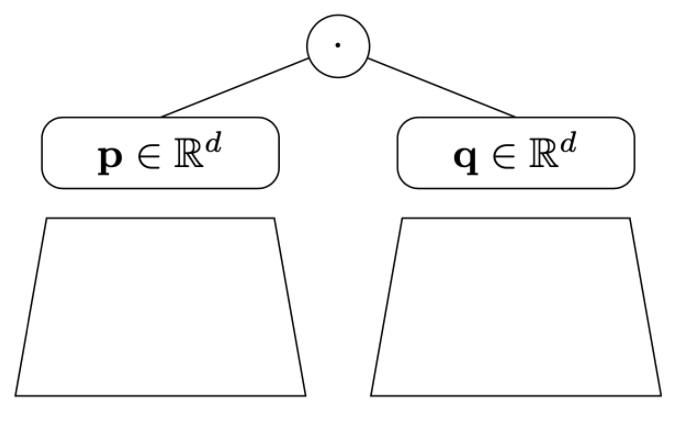


Модель состоит из двух нейросетевых частей:
1. Айтемная. Может принимать на вход контент документа, его статистики, признаки автора.
2. Пользовательская. Должна содержать некоторую агрегацию взаимодействий пользователя. 
   * В случае текстовых документов можно использовать bag of words сконкатенированных позитивов;
   * RNN по истории пользователя;
   * Transformer;
   * etc.

In [17]:
#!g1.1
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

device = 'cuda' if torch.cuda.is_available() else 'cpu'

Создадим torch датасеты по train и test данным

In [18]:
#!g1.1
def make_dataset(user_ratings, rating_col):
    users, items, ratings = [], [], []
    user_ids = user_encoder.transform(user_ratings['userId'])
    for user_id, items_with_ratings in tqdm_notebook(zip(user_ids, user_ratings[rating_col]),
                                                     total=len(user_ratings)):
        item_ids, item_ratings = zip(*json.loads(items_with_ratings.replace("'", '"')).items())
        item_ids = [item_to_id[item_id] for item_id in item_ids]
#         item_ids = item_encoder.transform(item_ids)
        for item_id, rating in zip(item_ids, item_ratings):
            users.append(user_id)
            items.append(item_id)
            ratings.append(rating)
    return TensorDataset(torch.tensor(users), torch.tensor(items), torch.tensor(ratings))

In [19]:
#!g1.1
train_dataset = make_dataset(user_ratings, 'trainRatings')
test_dataset = make_dataset(user_ratings, 'testRatings')

  0%|          | 0/75910 [00:00<?, ?it/s]

  0%|          | 0/75910 [00:00<?, ?it/s]

In [20]:
#!g1.1
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

В нашем семинаре реализуем самую простую возможную DSSM-like модель, модель обычной матричной факторизации.

In [25]:
#!g1.1
class MatrixDecompositionModel(nn.Module):
    def __init__(self, num_users, num_items, emb_size=10):
        super(MatrixDecompositionModel, self).__init__()
        
        # <YOUR CODE HERE>: user and item embeddings
        self.user_embeddings = nn.Embedding(num_users, emb_size)
        self.item_embeddings = nn.Embedding(num_items, emb_size)
        
    def forward(self, users, items):
        # <YOUR CODE HERE>: dot-product for all pairs in batch
        user_embs = self.user_embeddings(users)
        item_embs = self.item_embeddings(items)
        dot_product = (user_embs * item_embs).sum(dim=-1)
        
        return dot_product

In [30]:
#!g1.1
def plot_loss(train_loss, test_loss=None):
    clear_output(True)

    plt.figure(figsize=(10, 6))
    plt.plot(train_loss, label='Train')
    if test_loss is not None:
        plt.plot(test_loss, label='Test')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Train progress')
    plt.legend()
    
    plt.show()


def train(model, optimizer, train_loader, test_loader, num_epochs=5):
    train_loss_per_iteration = []
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for iteration, (users, items, ratings) in enumerate(tqdm_notebook(train_loader, total=len(train_loader))):
            users = users.to(device)
            items = items.to(device)
            ratings = ratings.to(device)

            optimizer.zero_grad()
            ratings_pred = model(users, items)
            
            # <YOUR CODE HERE>: backward step
            # ratings_prediction = ...
            # loss = ...
            loss = F.mse_loss(ratings_pred, ratings.float())
            loss.backward()
            optimizer.step()
            
            train_loss_per_iteration.append(loss.item())
            train_loss += loss.item()
            
            if iteration % 1000 == 0:
                plot_loss(train_loss_per_iteration)

        train_loss /= len(train_loader)
        
        model.eval()
        test_loss = 0.0
        for users, items, ratings in tqdm_notebook(test_loader, total=len(test_loader)):
            users = users.to(device)
            items = items.to(device)
            ratings = ratings.to(device)
            
            with torch.no_grad():
                ratings_pred = model(users, items)
            
            # loss = ...
            loss = F.mse_loss(ratings_pred, ratings.float())

            test_loss += loss.detach().cpu()
        test_loss /= len(test_loader)
        
        print(f'Epoch {epoch}: Train loss: {train_loss}, Test loss: {test_loss}')

In [31]:
#!g1.1
model = MatrixDecompositionModel(len(user_encoder.classes_), len(item_encoder.classes_), emb_size=8).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

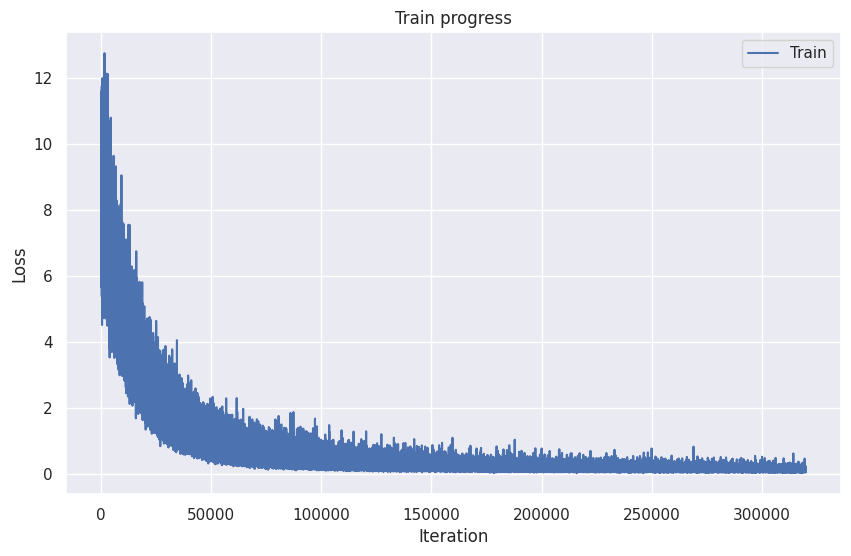

In [ ]:
#!g1.1
train(model, optimizer, train_loader, test_loader)